In [1]:
import os
import os.path as osp
from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [2]:
import torch
import cv2
import albumentations as albu

In [3]:
# import shutil
# def parse_filename_chambers(filename):
#     parts = filename.split('_')
#     pacient = parts[0]
#     passage = int(parts[1][1:])  # Extracting the number and converting to integer
#     number = int(parts[2])  # Removing the file extension and converting to integer
#     channel = parts[3].split('.')[0]
        
#     return pacient, passage, channel, number
    
# fn_dir = 'datasets/second/chambers_cropped'
# fn_list = [v for v in os.listdir(fn_dir) if v.endswith('.png')]
# for fn in fn_list:
#     pacient, passage, channel, number = parse_filename_chambers(fn)
#     exp = str(pacient.upper())
#     dst_fn = f'{exp}_{pacient}_p{passage}_{channel}_{number}.png'
#     src_fp = os.path.join(fn_dir, fn)
#     dst_fp = os.path.join(fn_dir, dst_fn)
#     # exp, pacient, passage, channel, number = parse_filename(dst_fn)
#     # print(src_fp, '->', dst_fp, exp, pacient, passage, channel, number)
#     shutil.move(src_fp, dst_fp)

In [4]:
def parse_filename(filename):
    parts = filename.split('_')
    exp = parts[0]
    pacient = parts[1]
    passage = int(parts[2][1:])  # Extracting the number and converting to integer
    channel = parts[3]
    number = int(parts[4].split('.')[0])  # Removing the file extension and converting to integer
        
    return exp, pacient, passage, channel, number

In [5]:
def get_squares(orig_size, square_size, border, ):
    w, h = orig_size
    square_w, square_h = square_size

    # square_w_with_border = square_w + 2 * border
    # square_h_with_border = square_h + 2 * border
    # square_with_border_size = (square_w_with_border, square_h_with_border)

    square_w_num, square_h_num = int(np.ceil(w / square_w)), int(np.ceil(h / square_h))
    full_size = (square_w * square_w_num, square_h * square_h_num)
    full_size_with_borders = (full_size[0] + 2 * border, full_size[1] + 2 * border)

    squares = []
    for start_w_idx in range(square_w_num):
        start_w = start_w_idx * square_w
        end_w = (start_w_idx + 1) * square_w

        for start_h_idx in range(square_h_num):
            start_h = start_h_idx * square_h
            end_h = (start_h_idx + 1) * square_h

            square_coords = [start_w,
                             start_h,
                             end_w,
                             end_h]
            square_with_borders_coords = [start_w,
                                          start_h,
                                          end_w + 2 * border,
                                          end_h + 2 * border]
            square_with_borders_coords_rev = [start_w + border,
                                              start_h + border,
                                              end_w + border,
                                              end_h + border]

            square_info_dict = dict(w=start_w_idx,
                                    h=start_h_idx,
                                    square_coords=square_coords,
                                    square_with_borders_coords=square_with_borders_coords,
                                    square_with_borders_coords_rev=square_with_borders_coords_rev)
            squares.append(square_info_dict)

    return full_size, full_size_with_borders, squares

In [6]:
def split_on_squares(image, squares, param_name):
    img_sq_list = []
    for sq in squares:
        img_sq = image[:, sq[param_name][1]:sq[param_name][3], sq[param_name][0]:sq[param_name][2]].copy()
        img_sq_list.append(img_sq)

    return img_sq_list
    
def split_image(image, full_size, squares, border):
    c = image.shape[0]

    image_with_borders = []
    for c_idx in range(c):
        image_resized_cur_c = cv2.resize(image[c_idx], full_size, interpolation=cv2.INTER_NEAREST)
        image_with_borders_cur_c = cv2.copyMakeBorder(image_resized_cur_c, border, border, border, border,
                                                      cv2.BORDER_REFLECT, None)
        image_with_borders.append(image_with_borders_cur_c)
    image_with_borders = np.stack(image_with_borders)

    img_sq_list = split_on_squares(image_with_borders, squares, 'square_with_borders_coords')

    return image_with_borders, img_sq_list


def unsplit_image(img_sq_list, squares, param_name, border):
    w_num, h_num = squares[-1]['w'] + 1, squares[-1]['w'] + 1
    square_size = (squares[0]['square_coords'][2], squares[0]['square_coords'][3])
    result_size = (img_sq_list[0].shape[0], square_size[0] * w_num, square_size[1] * h_num)
    result = np.zeros(result_size)
    for sq, img_sq in zip(squares, img_sq_list):
        result[:, sq[param_name][1]:sq[param_name][3], sq[param_name][0]:sq[param_name][2]] = img_sq[:,
                                                                                              border:square_size[
                                                                                                         0] + border,
                                                                                              border:square_size[
                                                                                                         1] + border]
    return result


def draw_square(image, sq, color):
    for c_idx in range(len(color)):
        image[c_idx][sq[1]:sq[3], sq[0]] = color[c_idx]
        image[c_idx][sq[1], sq[0]:sq[2]] = color[c_idx]
        image[c_idx][sq[1]:sq[3], sq[2]] = color[c_idx]
        image[c_idx][sq[3], sq[0]:sq[2]] = color[c_idx]

In [7]:
def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        # albu.PadIfNeeded(384, 480, always_apply=True, border_mode=0),
        # albu.Resize(384, 480)
    ]
    return albu.Compose(test_transform, is_check_shapes=False)


def to_tensor(x, **kwargs):
    return x.astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform

    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose

    """

    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform, is_check_shapes=False)

In [8]:
R, G, B = 0, 1, 2
channel_dict = dict(R=0, G=1, B=2)

img_dir = 'datasets/second/chambers_cropped'
fn_list = [v for v in os.listdir(img_dir) if v.endswith('.png')]
fn_list.sort()

fn_dict = dict()
for fn in tqdm(fn_list):
    exp, pacient, passage, channel, number = parse_filename(fn)
    if (exp, number) not in fn_dict.keys():
        fn_dict[(exp, number)] = dict(pacient=pacient, passage=passage)
    fn_dict[(exp, number)][channel] = fn
# pprint(fn_dict)

100%|███████████████████████████████████████| 60/60 [00:00<00:00, 559240.53it/s]


In [32]:
mode = 'BG'

G_ids = list()
dataset = list()
dataset_info  = list()
idx = 0

target_size = (1024, 1024)
interpolation = cv2.INTER_LINEAR
def check_and_resize(img, fn, target_size):
    if (img.shape[0], img.shape[1]) != target_size:
        # print('resized:', fn, img.shape)
        img = cv2.resize(img, target_size, interpolation=interpolation)
    # img /= img.max()
    return img

for k, info in tqdm(fn_dict.items()):
    pacient = info['pacient']
    passage = info['passage']

    img = np.zeros((2, target_size[0], target_size[1]), dtype=np.float32)

    error = False
    for idx, m in enumerate(mode):
        if m not in info.keys():
            error = True
            print(f'error: {m} not in info for {fn}')
            break
        img_c = plt.imread(osp.join(img_dir, info[m]))
        img_c = check_and_resize(img_c, info[m], target_size)
        img[idx] = img_c[..., channel_dict[m]]
        print(img[idx].max())
    if error:
        continue

    dataset.append(img)
    dataset_info.append([k, info])

dataset = np.stack(dataset)
print(dataset.shape)

 40%|█████████████████▌                          | 8/20 [00:00<00:00, 74.02it/s]

1.0
1.0
1.0
0.9999554
1.0
0.80262536
0.9948513
0.840275
0.735472
1.0
1.0
0.9999866
1.0
0.9991154
0.5831539
0.4685084
0.9390203
0.9969335
0.9822169
1.0
0.6627451
0.9098039
0.9996332
0.998516
1.0
0.827451
1.0
0.9997724


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 68.28it/s]


0.9987416
0.9987308
0.9997147
0.94484574
0.85457665
0.7003477
1.0
0.5137255
1.0
0.7864195
0.99959224
0.99865216
(20, 2, 1024, 1024)


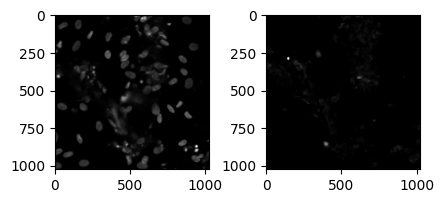

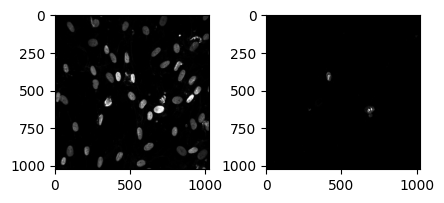

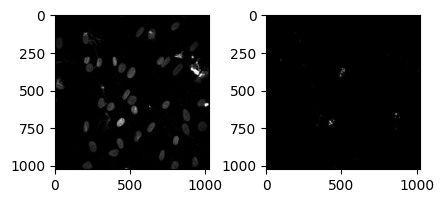

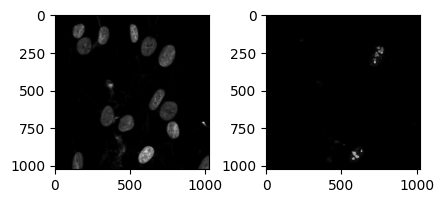

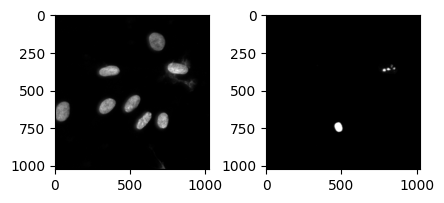

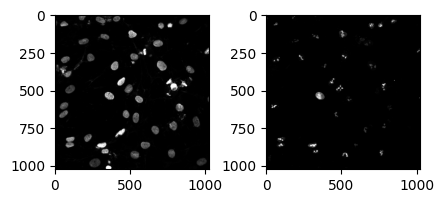

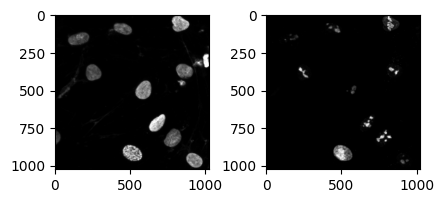

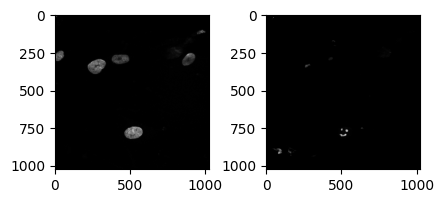

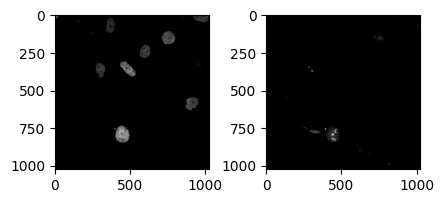

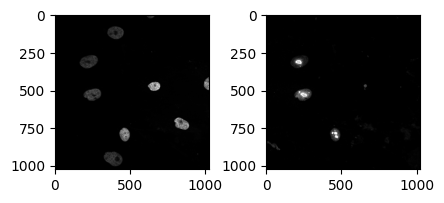

In [33]:
cmap = 'grey'
figsize = (5, 2)

for idx in range(10):
    fig, ax = plt.subplots(1,2, figsize=figsize)
    img = dataset[idx]
    # img[0] = cv2.normalize(img[0],  img[0], 0, 1, cv2.NORM_MINMAX)
    # img[1] = cv2.normalize(img[1],  img[1], 0, 1, cv2.NORM_MINMAX)

    ax[0].imshow(img[0], cmap=cmap)
    ax[1].imshow(img[1], cmap=cmap)

In [34]:
# model_load_fp = os.path.join('out', 'MSC_upd', 'Unet_timm-efficientnet-b6_2c_20240509_105457', 'best_model.pth')
# model_load_fp = os.path.join('out', 'MSC_filtered', 'Unet_timm-efficientnet-b6_20240424_133255', 'best_model.pth')
model_load_fp = os.path.join('out', 'MSC', 'Unet_timm-efficientnet-b6_20240417_144310', 'best_model.pth')

device = 'cuda'
model = torch.load(model_load_fp).to(device)

In [35]:
border = 64
square_size = (256, 256)
full_size, full_size_with_borders, squares = get_squares((dataset.shape[-2], dataset.shape[-1]), square_size, border)

preprocessing_fn = None
preprocessing = get_preprocessing(preprocessing_fn)
augmentation = get_validation_augmentation()

0it [00:00, ?it/s]

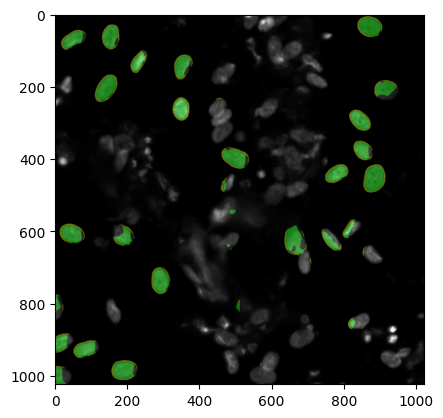

1it [00:01,  1.05s/it]

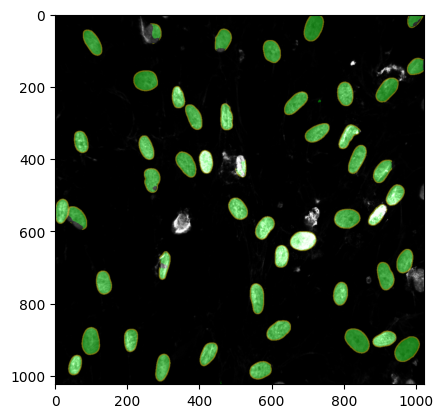

2it [00:02,  1.05s/it]

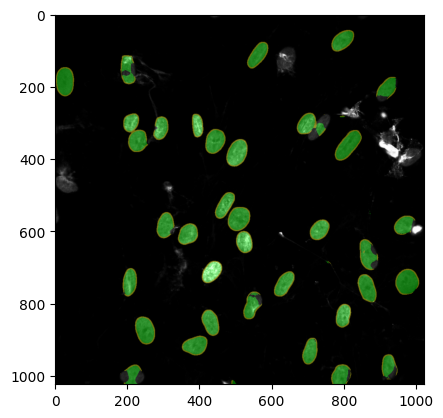

3it [00:03,  1.09s/it]

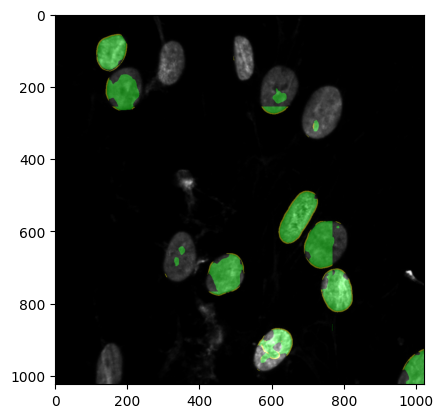

4it [00:04,  1.05s/it]

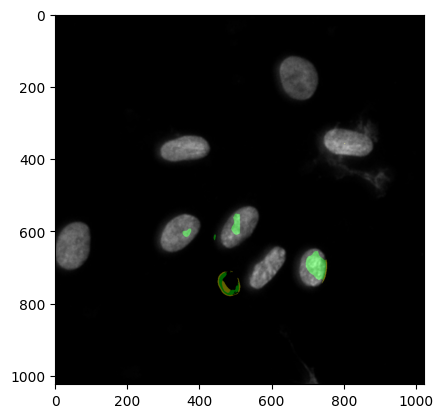

5it [00:05,  1.03s/it]

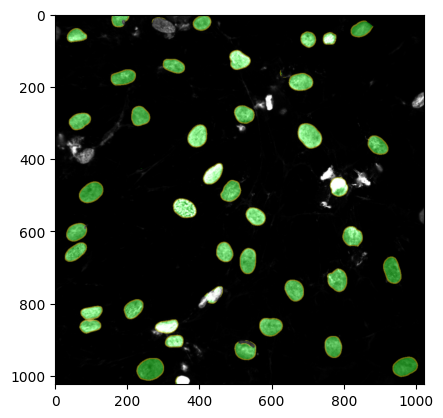

6it [00:06,  1.03s/it]

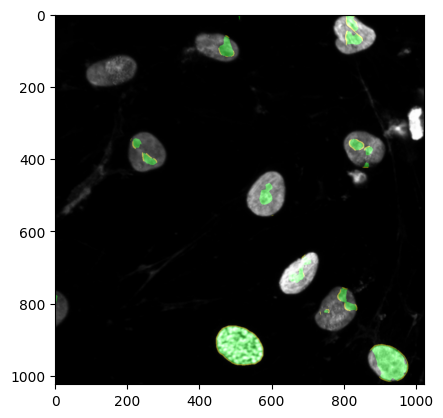

7it [00:07,  1.02s/it]

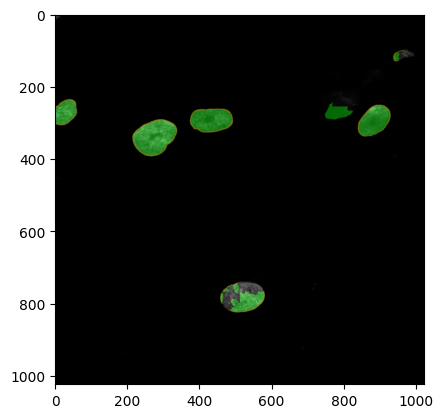

8it [00:08,  1.01s/it]

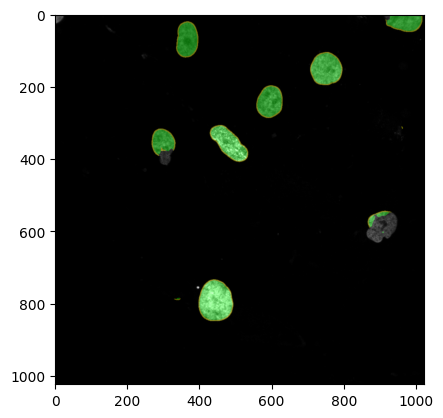

9it [00:09,  1.01s/it]

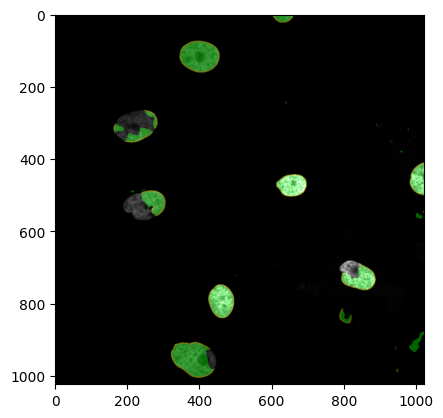

10it [00:10,  1.01s/it]

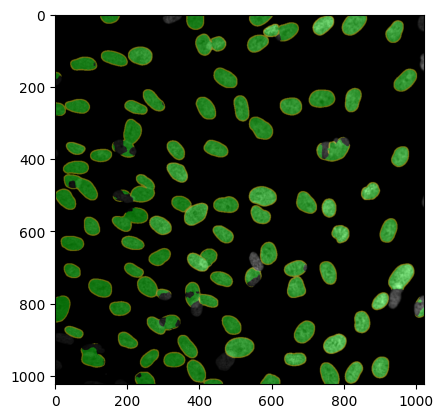

11it [00:11,  1.01s/it]

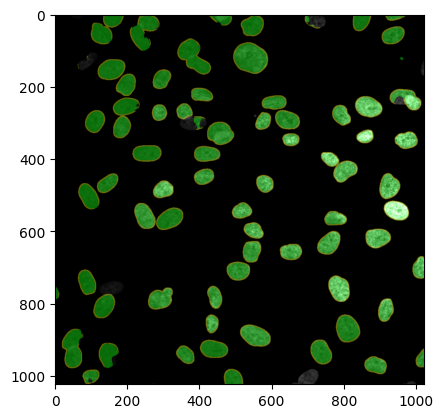

12it [00:12,  1.02s/it]

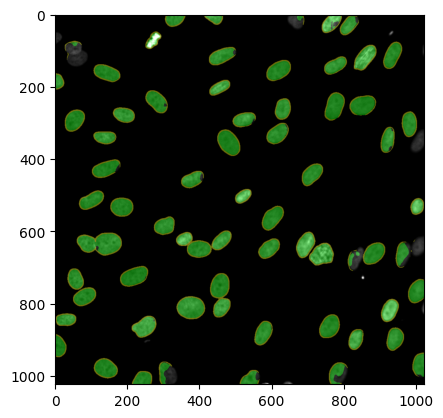

13it [00:13,  1.01s/it]

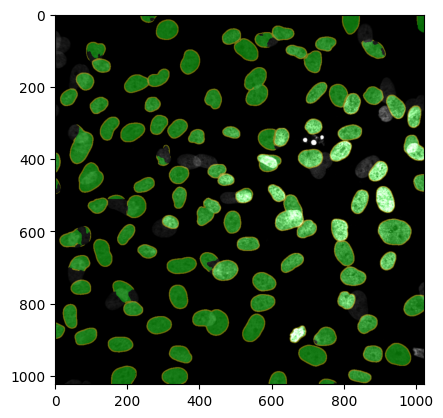

14it [00:14,  1.01s/it]

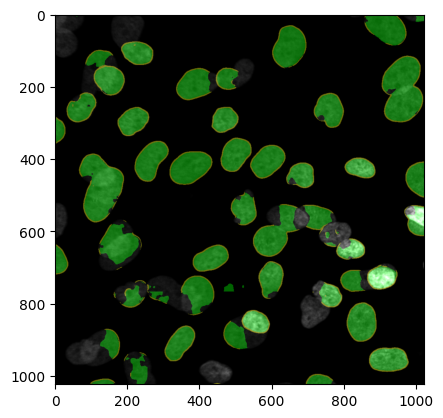

15it [00:15,  1.00s/it]

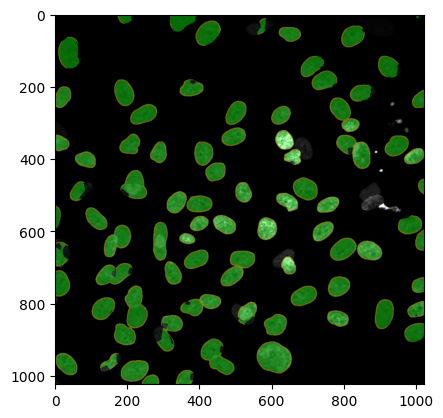

16it [00:16,  1.00s/it]

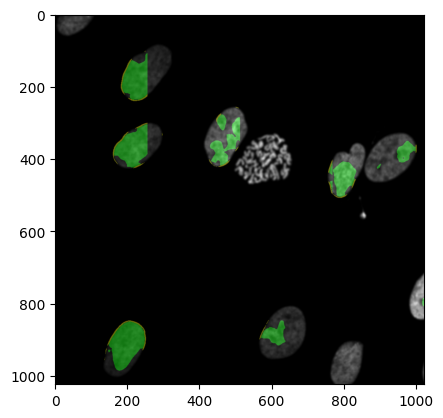

17it [00:17,  1.00it/s]

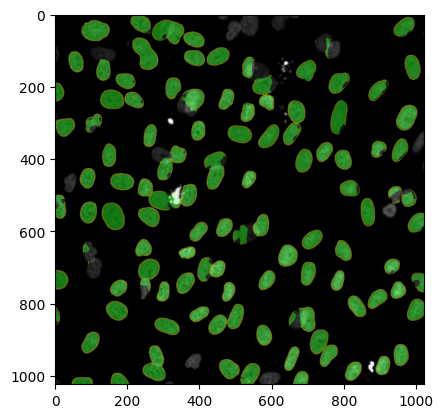

18it [00:18,  1.01s/it]

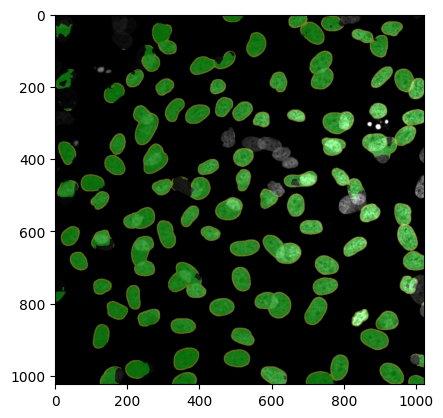

19it [00:19,  1.01s/it]

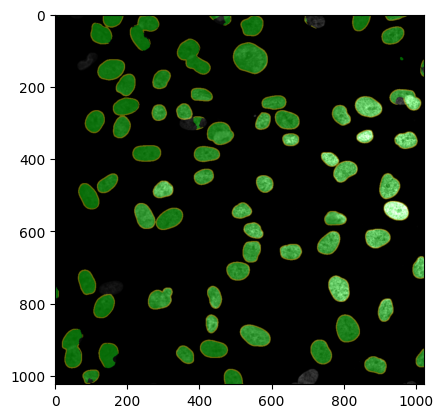

20it [00:20,  1.01s/it]


In [36]:
res_dir = osp.join('results', 'chambers_cropped', mode, '1class')
os.makedirs(res_dir, exist_ok=True)

for idx, img in tqdm(enumerate(dataset[:])):
    (exp, n), info = dataset_info[idx]
    img_list = list()
    pred_masks = list()
    _, img_sq_list = split_image(img, full_size, squares, border)
    for img_sq, sq in zip(img_sq_list, squares):
        if augmentation:
            sample = augmentation(image=img_sq.astype('float32'), )
            img_sq = sample['image']

        if preprocessing:
            sample = preprocessing(image=img_sq.astype('float32'))
            img_sq = sample['image']
        
        # img_sq[0] /= img_sq[0].max()
        # img_sq[1] /= img_sq[1].max()
        # img_sq[img_sq < 0.1] = 0
        
        in_img = torch.Tensor([img_sq]).to(device)
        img_list.append(img_sq)
        mask = model(in_img).detach().squeeze().cpu().numpy().round()
        if mask[1].sum() < mask[0].sum():
            m0, m1 = mask[0].copy(), mask[1].copy()
            mask[0], mask[1] = m1, m0
        mask[1][mask[0] == 1] = 1
        
        pred_masks.append(mask)
    restored_img = unsplit_image(img_list, squares, 'square_coords',border).astype(np.uint8)
    restored_pr = unsplit_image(pred_masks, squares, 'square_coords', border).astype(np.uint8)

    # pr_img = np.zeros((1024, 1024, 3), dtype=np.uint8)
    pr_img = plt.imread(osp.join(img_dir, info['B']))
    pr_img[..., R] = pr_img[..., B]
    pr_img[..., G] = pr_img[..., B]
    pr_img = check_and_resize(pr_img, info['B'], target_size) * 255
    
    pr_img[..., 0][restored_pr[0] == 1] += 100
    pr_img[..., 1][restored_pr[1] == 1] += 100
    
    pr_img = pr_img.clip(0, 255).astype(np.uint8)
    
    res_name = f"{exp}_{info['pacient']}_p{info['passage']}_{n}"
    plt.imsave(osp.join(res_dir, res_name+'.png'), pr_img)
    plt.imshow(pr_img)
    plt.show()
    with open(osp.join(res_dir, res_name+'.npy'), 'wb') as f:
        np.save(f, restored_pr)